# Explortatory analysis 

Notebook for exploratory analysis on tetrode data in the mPFC of a rat doing the parametric working memory (PWM) task.

Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


**TODO**
* deal w/ zeroing info
* figure out how to get spk waveform with new dict structure
* plotting iterations



## Libs & fxs

In [2]:
# settings

%load_ext autoreload
%autoreload 2

# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I/O & Wrangle

In [ ]:
"Helpful code for saving out"
# sess_names = np.array(['data_sdb_20190724_193007_fromSD', 'data_sdc_20190902_145404_fromSD', 'W122_07_27_2019_1_fromSD', 
#             'W122_08_06_2019_1_fromSD', 'W122_08_07_2019_1_fromSD', 'W122_08_31_2019_1_fromSD', 'W122_09_04_2019_1_fromSD',
#             'W122_09_09_2019_1_fromSD', 'W122_09_10_2019_1_fromSD', 'W122_09_11_2019_1_fromSD', 'W122_09_12_2019_1_fromSD',
#             'W122_09_19_2019_1_fromSD', 'W122_09_21_2019_1_fromSD', 'W122_09_24_2019_1_fromSD'])

#np.save('sess_names.npy', sess_names)


# # beh_df.to_csv(os.path.join(dir_name, sess_name, 'beh_df.csv'), index=False)

# # preloading spks_dict
# import pickle

# f = open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'),"wb")
# pickle.dump(spks_dict,f)
# f.close()

# f= open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'), "rb")
# loaded_dictionary = pickle.load(f)


In [90]:
# global
sess_names = np.load('sess_names.npy')

dir_name  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
sess_name = sess_names[1]
sess_dir = os.path.join(dir_name, sess_name)

# create paths
beh_path  = os.path.join(dir_name, sess_name, beh_mat)
spks_path = os.path.join(dir_name, sess_name, spks_mat)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict, "20190902")


C:\Users\brodylab\Documents\GitHub\jbreda_PWM_ephys_analysis\io_utils.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
beh_df

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off
0,1,viol,6,9,RIGHT,NaN,0.008904,0.007300,476.563229,478.330221,NaN,NaN,NaN,NaN,NaN
1,2,viol,4,4,RIGHT,RIGHT,0.053144,0.019683,479.869221,481.457220,NaN,NaN,NaN,NaN,NaN
2,3,hit,6,3,RIGHT,RIGHT,0.019683,0.007290,482.048223,491.384224,490.309221,482.098232,482.498223,488.499224,488.898223
3,4,miss,2,9,RIGHT,RIGHT,0.008904,0.007300,498.909227,504.188223,502.903229,498.960232,499.360221,501.359229,501.759230
4,5,hit,2,6,LEFT,RIGHT,0.002700,0.007290,505.471227,510.643223,509.341221,505.522228,505.922229,507.922222,508.321227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,401,hit,2,2,RIGHT,LEFT,0.007290,0.002700,5227.210220,5232.558223,5231.212228,5227.260225,5227.660226,5229.661221,5230.061221
401,402,hit,2,12,LEFT,RIGHT,0.002704,0.007300,5241.322233,5246.522218,5245.159224,5241.373230,5241.773230,5243.773224,5244.173227
402,403,hit,2,14,LEFT,LEFT,0.005985,0.007300,5251.930228,5256.937232,5255.634227,5251.980234,5252.381230,5254.381225,5254.781231
403,404,viol,6,7,LEFT,LEFT,0.007290,0.019683,5261.118223,5269.656222,NaN,NaN,NaN,NaN,NaN


In [92]:
spks_dict

{'date': '190902',
 'spk2fsm': array([  0.99994683, 130.6813586 ]),
 'fs': 30000,
 'trode_nums': [8, 10, 10, 10],
 'spk_qual': ['multi', 'multi', 'multi', 'multi'],
 'spk_times': [array([[ 630.68913607],
         [ 630.71466805],
         [ 630.73770016],
         ...,
         [5305.27491967],
         [5305.28535244],
         [5305.30828456]]),
  array([[ 630.80926302],
         [ 630.90905771],
         [ 630.91409078],
         ...,
         [5304.87194109],
         [5304.88334049],
         [5304.93253787]]),
  array([[ 630.85672716],
         [ 631.12857937],
         [ 635.01620597],
         ...,
         [5300.12316029],
         [5300.13319309],
         [5300.59860167]]),
  array([[ 630.66323745],
         [ 630.68966938],
         [ 630.72376757],
         ...,
         [5305.36471489],
         [5305.37978076],
         [5305.39241342]])],
 'mean_wav': [array([[-29.86769634, -26.33201295, -16.77566434,  -1.70596231,
           15.81754689,  31.30769942,  41.29871659,  44

## Dealing with 0ing out info

In [213]:
def load_masks(spks_dict, sess_dir):
    """Function for loading mask info stores in sorted in sorted session directory
    based on the active tetrodes in the session
    
    inputs
    ------
    trode_num : arr, what tetrode each cell is on in the session (1-32)
    sess_dir : path to directory for a sorted session with mask NPY files for each bundle
    
    returns
    -------
    mask_dict : dict, containing unique tetrodes for the session & mask info for bundles with
    cells. True = Masked, False = Nonmasked
    """
    
    # intialize space
    
    mask_dict = {}
    
    # deal with multiple cells on one tetrode
    unique_trodes = np.unique(spks_dict['trode_nums'])
    mask_dict['uniq_trodes'] = unique_trodes
         
    for trode in unique_trodes:
        
        # determine (unefficiently) which mask file is correct
        if trode <= 8:
            bndl = "bundle1_mask_info"
        elif trode > 8 <= 16:
            bndl = "bundle2_mask_info"
        elif trode > 16 <= 24:
            bndl = "bundle3_mask_info"
        elif trode > 24 <= 32:
            bndl = "bundle4_mask_info"
        else:
            print("trode not between 1-32, function will break")
            
        # load it, flatten & convert to bool (0.0 = noise, 1.0 = signal)
        bndl_mask = np.load(os.path.join(sess_dir, bndl))
        bndl_mask = bndl_mask.flatten()
        bndl_mask_bool = np.where(bndl_mask == 0.0, True, False) 
        mask_dict[bndl]= bndl_mask_bool
        
    return mask_dict   

In [214]:
def mask2fsm(mask_dict, spks_dict):
    
    """
    Quick function to use shape of boolean mask to create a second array in fsm time
    to allow for a 'common' timeframe between task events and ephys masking. Eventually 
    this should be extracted from trodes
    """
    # organize & assign
    fs = spks_dict['fs']
    key = list(mask_dict)[1] # grab mask info for first bundle in list
    total_samples = len(mask_dict[key])
    
    # create a array the same length of the bool with values in seconds at fs
    mask_sec = np.linspace(0, total_samples/fs, total_samples)
    
    # convert the time array above from spk time to fsm time
    mask_fsm = (mask_sec * spks_dict['spk2fsm'][0]) + spks_dict['spk2fsm'][1]
    
    mask_dict.update({'mask_fsm' : mask_fsm})
    
    return mask_dict


In [215]:
mask_test = load_masks(spks_dict, sess_dir)
mask_test = mask2fsm(mask_test, spks_dict)

In [216]:
mask_test

{'uniq_trodes': array([ 8, 10], dtype=uint8),
 'bundle1_mask_info': array([ True,  True,  True, ...,  True,  True,  True]),
 'bundle2_mask_info': array([ True,  True,  True, ...,  True,  True,  True]),
 'mask_fsm': array([ 130.6813586 ,  130.68139193,  130.68142527, ..., 5308.72076976,
        5308.72080309, 5308.72083642])}

In [208]:
def det_samples_masked(mask_dict, df):
    """
    
    inputs
    ------
    
    returns
    -------
    
    """
    
    # --- data frame prep
    # get only trials without violatios
    no_viol_df = df[df['hit_hist'] != 'viol']
    
    # grab start and stop indicies for window
    start = no_viol_df['c_poke']
    end = no_viol_df['aud2_off']
    
    # --- determining masks
    # determine where masks are, store keys for them
    mask_keys = []
    for f in range(1,5):
        key = "bundle{}_mask_info".format(f)
        if key in mask_dict:
            mask_keys.append(key)
    
    # --- extract masks using df trial times
    all_samples_masked = []
    
    # iterate over masks
    for mask in mask_keys:
        
        bndl_samples_masked = []
        
        # iterate over each trial
        for trial, row in no_viol_df.iterrows():
            
            # find time closesd to start & stop for each trial, return the idx in mask_fsm
            idx_s = np.searchsorted(mask_dict['mask_fsm'], start[trial], side = "left")
            idx_e = np.searchsorted(mask_dict['mask_fsm'], end[trial], side = "left")
            
            # use these indices to go back into trodes_time for each mask
            bndl_samples_masked.append(np.sum(mask_dict[mask][idx_s:idx_e]))
        
        all_samples_masked.append(bndl_samples_masked)
    
    return all_samples_masked

def find_unmasked_idx(all_samples_masked, df, threshold=1000):
    """
    
    inputs
    ------
    
    returns
    -------
    
    """
    
    all_unmasked_idxs = []
    
    
    # iterate over each bundle
    for bndl in range(len(all_samples_masked)):
        bndl_unmasked_idxs = []
        
        # if a trial has less than threshold # samples masked, grab the index
        for trial in range(len(all_samples_masked[bndl])):
            if all_samples_masked[bndl][trial] < threshold:
                bndl_unmasked_idxs.append(trial)
    
        all_unmasked_idxs.append(bndl_unmasked_idxs)
    
    return all_unmasked_idxs

def make_unmasked_dfs(all_unmasked_idx, df):
    """need to find a way to make a flexible amount of dataframs given masking & then return 
    that info. currently stuck on how to label each one so it maintains tetrode/bundle info
    in it. maybe can concat all together and have one column represent bndl info?"""
    

In [209]:
masked_samps = det_samples_masked(mask_test, beh_df)
unmasked_idxs = find_unmasked_idx(masked_samps, beh_df)

In [210]:
bndl1_df = beh_df.iloc[unmasked_idxs[0]]
bndl2_df = beh_df.iloc[unmasked_idxs[1]]

In [212]:
bndl2_df

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off
15,16,viol,2,4,RIGHT,RIGHT,0.053144,0.019683,624.708223,629.272218,NaN,NaN,NaN,NaN,NaN
16,17,hit,2,2,RIGHT,RIGHT,0.007290,0.002700,629.377224,634.437228,633.148224,629.428223,629.828223,631.828220,632.228224
22,23,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,684.046215,689.180224,687.884237,684.096224,684.496236,686.496224,686.896231
26,27,hit,2,3,RIGHT,LEFT,0.019683,0.007290,727.344221,732.372217,731.167224,727.394224,727.794228,729.794222,730.194226
53,54,hit,2,9,RIGHT,LEFT,0.008904,0.007300,1024.286218,1029.317223,1028.001222,1024.336222,1024.736218,1026.736223,1027.136223
58,59,hit,2,2,RIGHT,RIGHT,0.007290,0.002700,1073.215232,1078.645221,1077.205227,1073.266215,1073.666215,1075.666229,1076.066219
59,60,hit,4,6,LEFT,RIGHT,0.002700,0.007290,1085.405232,1092.579224,1091.272220,1085.456219,1085.856232,1089.856218,1090.256219
71,72,hit,2,9,RIGHT,RIGHT,0.008904,0.007300,1207.626223,1212.623225,1211.379222,1207.677222,1208.077223,1210.076229,1210.476225
72,73,hit,4,8,LEFT,RIGHT,0.019683,0.053144,1222.761223,1229.967216,1228.819222,1222.811225,1223.211227,1227.212217,1227.611223
74,75,hit,4,10,RIGHT,LEFT,0.013248,0.007300,1249.305226,1256.391221,1255.092228,1249.355234,1249.756222,1253.756218,1254.155228


# Plotting 2 second, L hit trials

In [16]:
# filter dataframe
beh_df_d2_hl = beh_df[(beh_df['correct_side'] == 'LEFT') & (beh_df['delay'] == 2)
       & (beh_df['hit_hist'] == 'hit')]


# initilaize
events = ['c_poke', 'aud1_on', 'aud2_on', 'aud1_on']
windows = [[-300,700], [-500,1000], [-500, 1000], [-1000,2300]]

# create
neuron_rasters = get_neuron_rasters(neurons, events, windows, df=beh_df_d2_hl)
neuron_psths = get_neuron_psths(neurons, events, windows, df=beh_df_d2_hl)

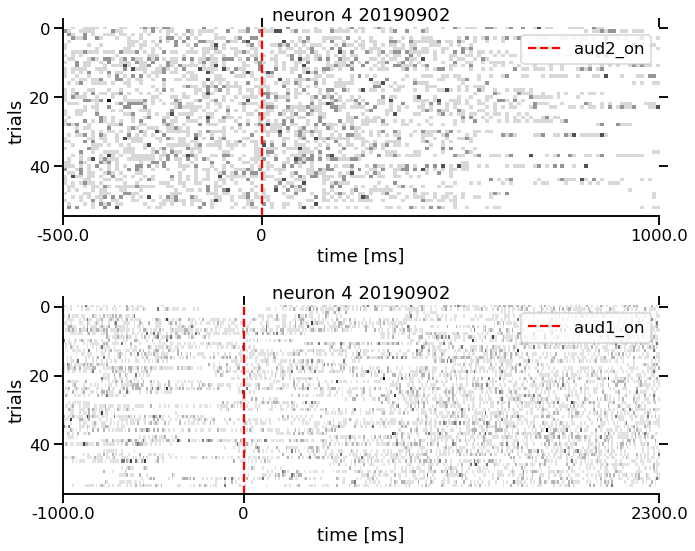

In [17]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 3
cc = 2
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_raster(neuron_rasters[nn][cc+1], axis = ax[1], event_name=events[cc+1], cmap="Greys")

# neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

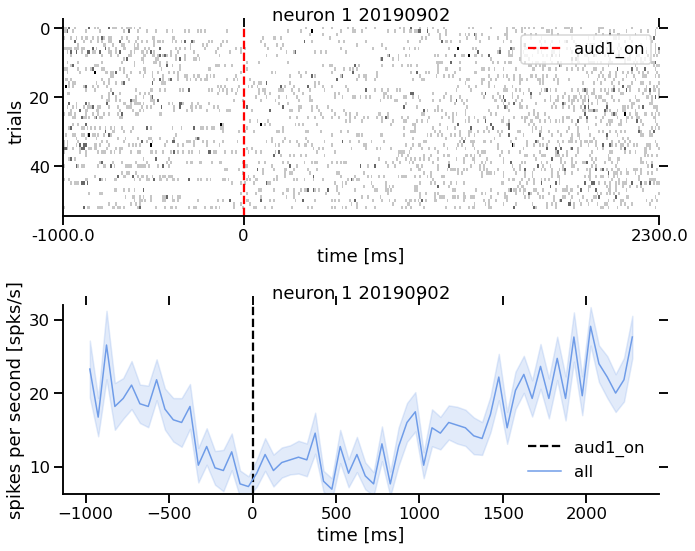

In [19]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 0
cc = 3

# neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[0], event_name=events[cc])
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

## Rogue plots

In [ ]:
nn = 0
tt = 1
mean_wave = spks_dict['mean_wav'][nn][0][tt].T
std = spks_dict['std_wav'][nn][0][tt].T
plt.plot(mean_wave)
plt.fill_between(np.arange(len(std)), mean_wave + std, mean_wave - std, alpha = 0.2)

In [140]:
neurons[0].name

'1 20190902'

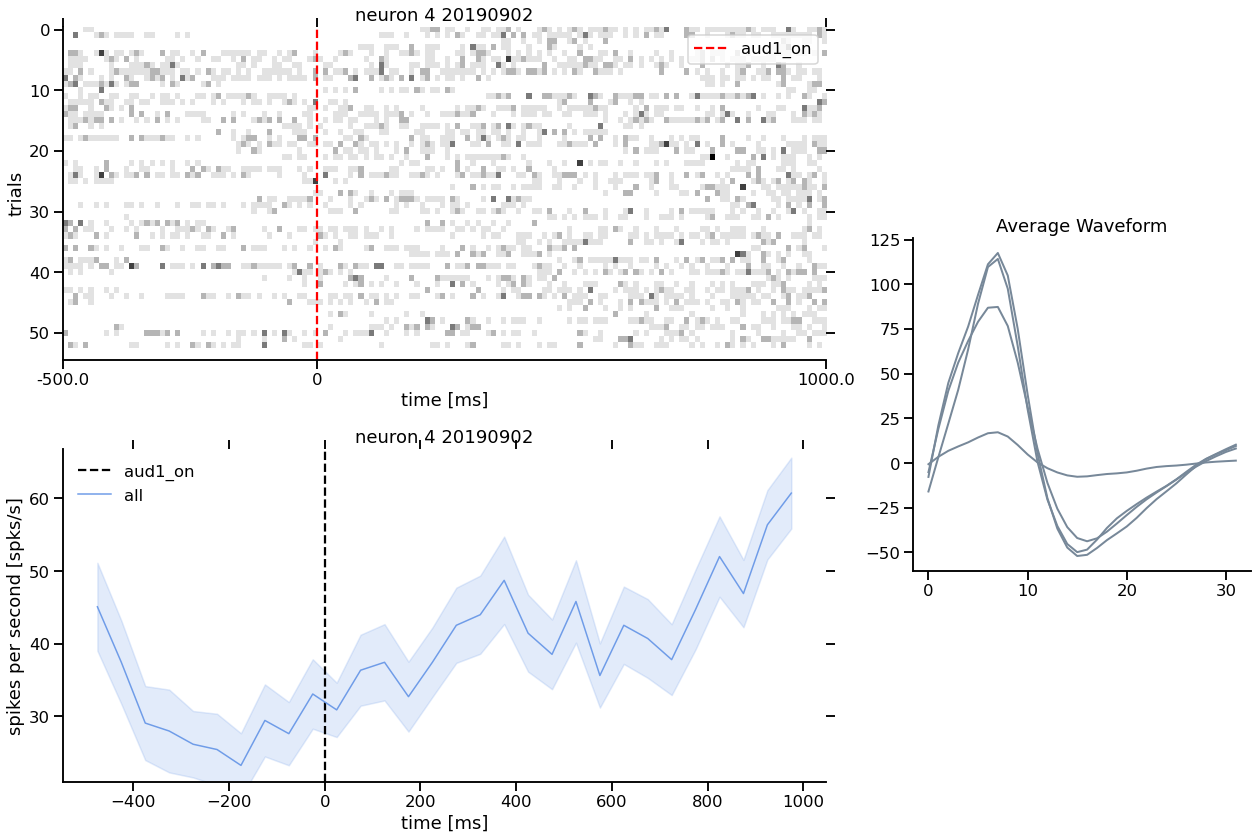

In [20]:
sns.set_context("talk")
fig = plt.figure(figsize=(18,12))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=2, colspan=2) 
ax2 = plt.subplot2grid((4, 3), (2, 0), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)


nn = 3
cc = 1
wave_snippet = spks_dict['waves_mn']
n3 = mean_wave = spks_dict['waves_mn'][nn][0]

neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax1, event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax2, event_name=events[cc])
for i in range(4):
    ax3.plot(n3[i],color = 'lightslategrey',lw=2)
    
ax3.set_title('Average Waveform')

save_name=neurons[0].name
fig.savefig('neuron1.jpeg')
